In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal

In [3]:
geo = pd.read_csv('../datasets/hackathon_processed.csv')
geo.head(10)

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,1815.0,JURASSIC,LIMESTONE,75.0,55.2,21.0,410.0
1,ABU GHARADIG,BAHARIYA,EGYPT,AFRICA,ABU GHARADIG,EXTENSION,29.7422,28.4925,GUPCO,ONSHORE,GAS-CONDENSATE,MATURE PRODUCTION,RIFT,3084.6,CRETACEOUS,SANDSTONE,223.5,43.2,10.0,8.0
2,ABU MADI-EL QARA,ABU MADI (LEVEL II),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,GAS,DECLINING PRODUCTION,WRENCH,2952.9,NEOGENE,THINLY-BEDDED SANDSTONE,34.5,19.8,22.0,200.0
3,ABU MADI-EL QARA,ABU MADI (LEVEL III),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,GAS,DECLINING PRODUCTION,WRENCH,3149.7,NEOGENE,SANDSTONE,152.7,123.0,20.0,300.0
4,AL HUWAISAH,SHUAIBA,OMAN,MIDDLE EAST,FAHUD SALT,COMPRESSION,21.9607,56.0452,PDO,ONSHORE,OIL,REJUVENATING,SALT,1486.5,CRETACEOUS,LIMESTONE,75.0,30.0,21.0,60.0
5,ALABAMA FERRY,UPPER GLEN ROSE D ZONE,USA,NORTH AMERICA,GULF OF MEXICO NORTHERN ONSHORE,GRAVITY,31.2143,-95.7981,NUMEROUS,ONSHORE,OIL,MATURE PRODUCTION,PASSIVE MARGIN,2610.0,CRETACEOUS,LIMESTONE,28.5,4.5,12.0,20.0
6,ALBA,ALBA,UK,EUROPE,NORTH SEA CENTRAL,NaN,58.0692,1.0784,CHEVRON,OFFSHORE,OIL,DECLINING PRODUCTION,RIFT,1692.6,PALEOGENE,THINLY-BEDDED SANDSTONE,90.0,81.0,NaN,3500.0
7,ALBION-SCIPIO,TRENTON-BLACK RIVER,USA,NORTH AMERICA,MICHIGAN,NaN,41.9937,-84.6016,NUMEROUS,ONSHORE,OIL,NEARLY DEPLETED,INTRACRATONIC,1140.0,ORDOVICIAN,DOLOMITE,180.0,120.0,NaN,10.0
8,ALIBEKMOLA,KT I,KAZAKHSTAN,FORMER SOVIET UNION,CASPIAN NORTH,COMPRESSION,48.4740,57.6667,KAZAKHOIL AKTOBE,ONSHORE,OIL,DEVELOPING,SUB-SALT,1800.0,CARBONIFEROUS,LIMESTONE,90.0,31.5,10.0,20.0
9,ALIBEKMOLA,KT II,KAZAKHSTAN,FORMER SOVIET UNION,CASPIAN NORTH,COMPRESSION,48.4740,57.6667,KAZAKHOIL AKTOBE,ONSHORE,OIL,DEVELOPING,SUB-SALT,2874.0,CARBONIFEROUS,LIMESTONE,182.1,32.4,10.0,20.0


In [4]:
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Gross','Netpay','Porosity','Permeability', 'Depth']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [5]:
geo_coded, label_coder = code_categories(geo, 'label', ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type'])

In [6]:
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', ['Gross','Netpay','Porosity','Permeability', 'Depth'])

In [7]:
geo_only_discrete, discrete_coder = discretization(geo, 'equal_frequency', ['Gross','Netpay','Porosity','Permeability', 'Depth'])

In [8]:
geo_nodes = get_nodes_type(geo)
geo_nodes

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont'}

In [9]:
bn_geo = structure_learning(geo_discrete, 'evo', 'K2', geo_nodes)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is -3591.5064026006676
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.0 min
Best metric is -3935.2377147540956
Generation num: 1
max_depth: 3, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is -4297.134510683069
Generation num: 2
max_depth: 3, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is -4297.134510683069
Generat

TypeError: object of type 'NoneType' has no len()

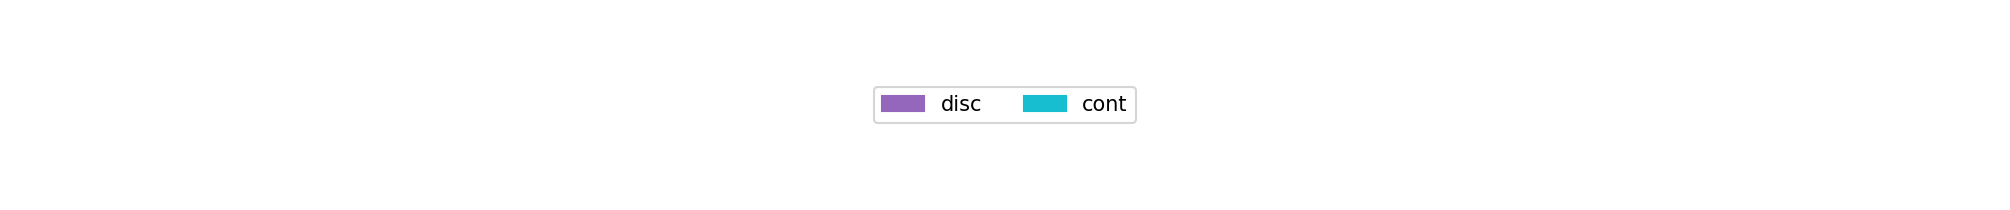

In [10]:
draw_BN(bn_geo, geo_nodes, 'evo_net')

In [11]:
params = parameter_learning(geo, geo_nodes, bn_geo)

In [12]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [13]:
acc, rmse = calculate_acc(geo_bn, geo, columns)

In [14]:
acc

{'Tectonic regime': 0.48,
 'Period': 0.26,
 'Lithology': 0.56,
 'Structural setting': 0.28,
 'Hydrocarbon type': 0.75}

In [15]:
rmse

{'Gross': 356.19,
 'Netpay': 58.76,
 'Porosity': 7.55,
 'Permeability': 1148.48,
 'Depth': 884.07}

In [69]:
discrete_type = {'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Gross': 'disc',
 'Netpay': 'disc',
 'Porosity': 'disc',
 'Permeability': 'disc',
 'Depth': 'disc'}

In [70]:
bn_discrete = structure_learning(geo_discrete, 'HC', 'K2', discrete_type)

  0%|          | 11/1000000 [00:01<41:39:59,  6.67it/s]


In [78]:
params = parameter_learning(geo_only_discrete, discrete_type, bn_discrete)

In [79]:
save_structure(bn_discrete, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [80]:
accuracy_dict = dict()
rmse_dict = dict()
pred_param = [[0 for j in range(geo.shape[0])] for i in range(len(columns))]
real_param = [[0 for j in range(geo.shape[0])] for i in range(len(columns))]
for i in range(geo_discrete.shape[0]):
    test = dict(geo_only_discrete.iloc[i, :])
    #test = dict([(k, str(v)) for k, v in test.items()])
    for n, key in enumerate(columns):
        train_dict = copy(test)
        train_dict.pop(key)
        if discrete_type[key] == 'disc':
            agg = SampleAggregator()
            sample = agg.aggregate(geo_bn.randomsample(2000, train_dict))
            sorted_res = sorted(sample[key].items(), key=operator.itemgetter(1), reverse=True)
            pred_param[n][i] = sorted_res[0][0]
            real_param[n][i] = test[key]


NameError: name 'node_type' is not defined

In [81]:
for n, key in enumerate(columns):
    if discrete_type[key] == 'disc':
        accuracy_dict[key] = round(accuracy_score(real_param[n], pred_param[n]), 2)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [82]:
accuracy_dict

{'Tectonic regime': 0.48,
 'Period': 0.36,
 'Lithology': 0.56,
 'Structural setting': 0.56,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [83]:
cont_real = real_param[4:]

In [85]:
cont_pred = pred_param[4:]

In [92]:
for i in range(0,5,1):
    cont_real[i] = [int(x) for x in cont_real[i]]
    cont_pred[i] = [int(x) for x in cont_pred[i]]

In [97]:
pd.DataFrame(np.transpose(cont_real))

,0,1,2,3,4
0,2,3,3,3,2
1,3,3,0,1,4
2,1,1,3,3,4
3,3,4,3,3,4
4,2,2,3,2,1
...,...,...,...,...,...
437,1,1,4,4,1
438,1,1,3,2,1
439,3,3,1,0,4
440,2,0,3,1,0


In [98]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(cont_real), columns=['Gross','Netpay','Porosity','Permeability', 'Depth']), ['Gross','Netpay','Porosity','Permeability', 'Depth'], discrete_coder)

In [99]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(cont_pred), columns=['Gross','Netpay','Porosity','Permeability', 'Depth']), ['Gross','Netpay','Porosity','Permeability', 'Depth'], discrete_coder)

In [106]:
round(mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False), 2)

1311.41

In [27]:
sample_geo = geo.loc[geo['Lithology'] == 'SANDSTONE']

In [35]:
from sklearn.preprocessing import PowerTransformer



pt = PowerTransformer()
data = pt.fit_transform(np.transpose([sample_geo['Permeability'].values]))

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

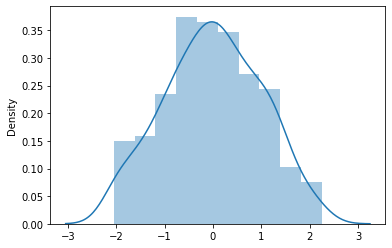

In [36]:
sns.distplot(data)

In [37]:
stats.shapiro(data)

ShapiroResult(statistic=0.9875103831291199, pvalue=0.029704926535487175)

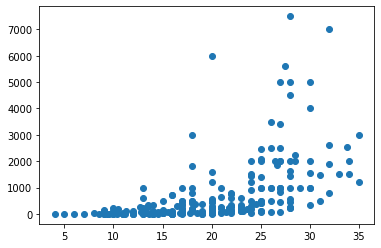

In [15]:
plt.scatter(sample_geo['Porosity'].values, sample_geo['Permeability'].values)

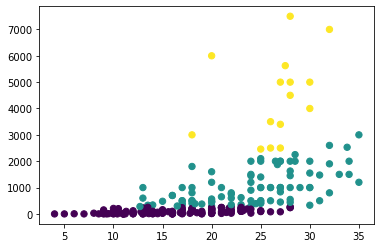

In [16]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(sample_geo[['Porosity', 'Permeability']].values)
labels = gmm.predict(sample_geo[['Porosity', 'Permeability']].values)
plt.scatter(sample_geo['Porosity'], sample_geo['Permeability'], c=labels, s=40, cmap='viridis')

In [17]:
sample_geo['labels'] = labels

<ipython-input-17-9b61972398ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_geo['labels'] = labels


In [19]:
means_parent = [list(l)[0:-1] for l in list(gmm.means_)]
mean_node = [list(l)[-1] for l in list(gmm.means_)]

In [20]:
means_parent

[[16.390294974666816], [23.496644836143467], [26.887263651484954]]

In [21]:
mean_node

[84.92937426745506, 948.8982815724421, 4155.014332757755]

In [44]:
small_sample = sample_geo.loc[sample_geo['labels'] == 2]

In [46]:
np.var(small_sample['Porosity'].values)

12.015555555555554

In [47]:
from scipy.stats import norm
mean, std = norm.fit(small_sample['Porosity'])

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(sample_geo[['Porosity', 'Permeability']].values)

In [22]:
kmeans.cluster_centers_

array([[  27.83333333, 5513.88888889],
       [  18.16896552,  247.68128079],
       [  27.38888889, 2001.72222222]])

In [19]:
sample = copy(sample_geo)
sample['labels'] = labels
variances = []

In [20]:
for i in range(0,3,1):
    print(i)
    sample_small = sample.loc[sample['labels'] == i]
    variances.append(sample_small['Permeability'].var())

0
1
2


In [21]:
variances

[16375.0, 320000.0, 0.0]

In [94]:
sample_geo['Porosity'].var()

42.80301162335119

In [90]:
mean_parent = [list(l)[-1] for l in list(gmm.means_)]
mean_parent

[84.92937426745507, 4155.014332757755, 948.8982815724424]

In [67]:
gmm.pr

array([[  23.49664484,  948.89828157],
       [  16.39029497,   84.92937427],
       [  26.88726365, 4155.01433276]])

In [30]:
stats.kstest(sample_geo['Depth'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [31]:
params = stats.uniform.fit(sample_geo['Depth'])

In [32]:
stats.kstest(sample_geo['Depth'], 'uniform', params)

KstestResult(statistic=0.21525050292173575, pvalue=0.0013048369535451076)

In [12]:
from sklearn import linear_model

clf = linear_model.LinearRegression()
clf.fit(np.transpose([sample_geo['Porosity'].values]), sample_geo['Permeability'].values)

LinearRegression()

In [13]:
clf.intercept_

-1253.578582747665

In [15]:
socio = pd.read_csv('../datasets/vk_interests_finance.csv')
socio.head(10)

,first_name,last_name,sex,age,city_id,has_high_education,relation,num_of_relatives,followers_count,status,...,top3,top3_mean,game_sum,is_gamer,parent_sum,is_parent,driver_sum,is_driver,pets_sum,has_pets
0,Darya,Tsiberkina,1.0,33,2,0,4,2,486,8,...,5812,1277.784568,0.0,0,9968.00,1,0.0,0,0.0,0
1,Gleb,Kotenev,2.0,18,2,0,0,2,0,5,...,5814,384.000000,0.0,0,0.00,0,0.0,0,0.0,0
2,Anna,Pavlova,1.0,34,2,0,0,2,7,0,...,6011,24000.000000,0.0,0,0.00,0,0.0,0,0.0,0
3,Serega,Martynov,2.0,39,2,0,0,2,7,10,...,5411,142.175000,0.0,0,0.00,0,0.0,0,0.0,0
4,Maria,Pavlyukova,1.0,0,2,0,0,2,144,0,...,6011,1095.238095,0.0,0,60331.59,1,0.0,0,80.0,0
5,Yury,Golubkov,2.0,47,2,0,0,2,0,0,...,5964,760.580000,0.0,0,0.00,0,0.0,0,0.0,0
6,Svetlana,Muratova,1.0,48,2,0,4,2,30,0,...,5411,113.000000,0.0,0,0.00,0,0.0,0,0.0,0
7,Ivan,Poletaev,2.0,0,2,0,0,2,53,23,...,5411,446.565263,1000.0,1,0.00,0,0.0,0,0.0,0
8,Anastasia,Yaguzhinskaya,1.0,25,1,0,0,2,111,3,...,5499,185.523529,0.0,0,0.00,0,0.0,0,1287.0,0
9,Valentina,Trokhova,1.0,55,2,0,0,12,56,0,...,5499,345.572472,0.0,0,0.00,0,0.0,0,0.0,0


In [16]:
columns = ['age', 'sex', 'relation', 'mean_tr', 'median_tr', 'tr_per_month', 'is_parent', 'is_driver', 'has_pets']
socio = socio[columns]
socio.dropna(inplace=True)
socio.reset_index(inplace=True, drop=True)

In [17]:
socio['sex'] = socio['sex'].apply(lambda x: int(x))
socio

,age,sex,relation,mean_tr,median_tr,tr_per_month,is_parent,is_driver,has_pets
0,33,1,4,1834.965024,727.500,30.198341,1,0,0
1,18,2,0,179.375000,94.075,8.207697,0,0,0
2,34,1,0,4877.224375,3250.000,2.510258,0,0,0
3,39,2,0,5816.299912,500.000,8.228150,0,0,0
4,0,1,0,528.680410,182.500,13.460532,1,0,0
...,...,...,...,...,...,...,...,...,...
93613,20,2,0,324.110811,130.000,2.317211,0,0,0
93614,47,1,0,3502.901130,860.000,30.958948,1,0,0
93615,57,1,0,17412.500000,13500.000,1.932500,0,0,0
93616,58,2,4,5276.737619,1039.000,5.017067,1,0,0


In [18]:
socio['sex'] = socio['sex'].apply(lambda x: str(x))
socio['relation'] = socio['relation'].apply(lambda x: str(x))
socio['is_parent'] = socio['is_parent'].apply(lambda x: str(x))
socio['is_driver'] = socio['is_driver'].apply(lambda x: str(x))
socio['has_pets'] = socio['has_pets'].apply(lambda x: str(x))

In [19]:
socio_types = get_nodes_type(socio)
socio_types

{'age': 'disc',
 'sex': 'disc',
 'relation': 'disc',
 'mean_tr': 'cont',
 'median_tr': 'cont',
 'tr_per_month': 'cont',
 'is_parent': 'disc',
 'is_driver': 'disc',
 'has_pets': 'disc'}

In [20]:
socio_types = {'age': 'cont',
 'sex': 'disc',
 'relation': 'disc',
 'mean_tr': 'cont',
 'median_tr': 'cont',
 'tr_per_month': 'cont',
 'is_parent': 'disc',
 'is_driver': 'disc',
 'has_pets': 'disc'}

In [21]:
discrete_socio, coder_socio = discretization(socio, 'equal_frequency', ['age', 'mean_tr', 'median_tr', 'tr_per_month'])

In [22]:
bn_socio = structure_learning(discrete_socio, 'HC', 'K2', socio_types)

  0%|          | 24/1000000 [00:07<89:26:32,  3.11it/s]


In [23]:
params = parameter_learning(socio, socio_types, bn_socio)

In [24]:
save_structure(bn_socio, 'socio_net')
skel = read_structure('socio_net')
save_params(params, 'socio_net_param')
params = read_params('socio_net_param')
socio_bn = HyBayesianNetwork(skel, params)

In [25]:
sample_socio = socio.sample(500)

In [26]:
accuracy_dict = dict()
rmse_dict = dict()
pred_param = [[0 for j in range(sample_socio.shape[0])] for i in range(len(columns))]
real_param = [[0 for j in range(sample_socio.shape[0])] for i in range(len(columns))]
for i in range(sample_socio.shape[0]):
    test = dict(sample_socio.iloc[i, :])
    for n, key in enumerate(columns):
        train_dict = copy(test)
        train_dict.pop(key)
        if socio_types[key] == 'disc':
            agg = SampleAggregator()
            sample = agg.aggregate(socio_bn.randomsample(2000, train_dict))
            sorted_res = sorted(sample[key].items(), key=operator.itemgetter(1), reverse=True)
            pred_param[n][i] = sorted_res[0][0]
            real_param[n][i] = test[key]
        if socio_types[key] == 'cont':
            sample = pd.DataFrame(socio_bn.randomsample(2000, train_dict))
            sample = sample.loc[sample[key] >= 0]
            if sample.shape[0] == 0:
                print(i)
            else:
                pred = np.mean(sample[key].values)
                pred_param[n][i] = pred
                real_param[n][i] = test[key]
for n, key in enumerate(columns):
    if socio_types[key] == 'disc':
        accuracy_dict[key] = round(accuracy_score(real_param[n], pred_param[n]), 2)
    if socio_types[key] == 'cont':
        rmse_dict[key] = round(mean_squared_error(real_param[n], pred_param[n], squared=False), 2)

In [27]:
accuracy_dict

{'sex': 0.63,
 'relation': 0.77,
 'is_parent': 0.61,
 'is_driver': 0.99,
 'has_pets': 0.94}

In [28]:
rmse_dict

{'age': 14.49,
 'mean_tr': 25157.59,
 'median_tr': 30837.2,
 'tr_per_month': 27.02}

In [166]:
discrete_types = {'age': 'disc',
 'sex': 'disc',
 'relation': 'disc',
 'mean_tr': 'disc',
 'median_tr': 'disc',
 'tr_per_month': 'disc',
 'is_parent': 'disc',
 'is_driver': 'disc',
 'has_pets': 'disc'}

In [167]:
params = parameter_learning(discrete_socio, discrete_types, bn_socio)

In [168]:
save_structure(bn_socio, 'socio_net')
skel = read_structure('socio_net')
save_params(params, 'socio_net_param')
params = read_params('socio_net_param')
socio_bn = HyBayesianNetwork(skel, params)

In [169]:
sample_socio = discrete_socio.sample(500)

In [170]:
accuracy_dict = dict()
rmse_dict = dict()
pred_param = [[0 for j in range(sample_socio.shape[0])] for i in range(len(columns))]
real_param = [[0 for j in range(sample_socio.shape[0])] for i in range(len(columns))]
for i in range(sample_socio.shape[0]):
    test = dict(sample_socio.iloc[i, :])
    #test = dict([(k, str(v)) for k, v in test.items()])
    for n, key in enumerate(columns):
        train_dict = copy(test)
        train_dict.pop(key)
        if discrete_types[key] == 'disc':
            agg = SampleAggregator()
            sample = agg.aggregate(socio_bn.randomsample(2000, train_dict))
            sorted_res = sorted(sample[key].items(), key=operator.itemgetter(1), reverse=True)
            pred_param[n][i] = sorted_res[0][0]
            real_param[n][i] = test[key]

In [171]:
for n, key in enumerate(columns):
    if discrete_types[key] == 'disc':
        accuracy_dict[key] = round(accuracy_score(real_param[n], pred_param[n]), 2)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [172]:
accuracy_dict

{'age': 0.0,
 'sex': 0.58,
 'relation': 0.81,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0,
 'is_parent': 0.61,
 'is_driver': 1.0,
 'has_pets': 0.93}

In [178]:
real_cont = []
for i in [0, 3, 4, 5]:
   real_cont.append(real_param[i])


In [179]:
pred_cont = []
for i in [0, 3, 4, 5]:
   pred_cont.append(pred_param[i])

In [181]:
for i in range(0,4,1):
    real_cont[i] = [int(x) for x in real_cont[i]]
    pred_cont[i] = [int(x) for x in pred_cont[i]]

In [182]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real_cont), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], coder_socio)

In [183]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred_cont), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], coder_socio)

In [187]:
round(mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False), 2)

116.92

In [4]:
mehra = pd.read_csv('../datasets/mehra.csv')
mehra.head(10)

,Unnamed: 0,Region,Zone,Type,Year,Season,Month,Day,Hour,Latitude,...,tp,blh,ssr,CVD60,no2,o3,so2,co,pm10,pm2.5
0,1,North West,Teesside Urban Area,Background Urban,1982,Fall,12,9,10,53.004256,...,-0.000384,-132.536379,1.764807e+05,0.253973,70.912242,13.886300,14.571613,1.281367,33.582153,18.641989
1,2,East of England,Greater Manchester Urban Area,Background Rural,1982,Spring,3,14,21,52.082833,...,1.647048,519.511962,-2.275298e+09,0.216665,-115661.469371,12.107172,31073.785918,0.134127,33.854881,18.635103
2,3,West Midlands,West Midlands,Industrial Urban,1986,Spring,8,1,3,53.130817,...,-0.001874,186.536382,2.484053e+06,0.171526,86.566005,18.724361,18.512337,1.583104,35.983265,18.627684
3,4,West Midlands,Nottingham Urban Area,Traffic Urban,1991,Summer,12,26,3,52.740293,...,-0.000337,38.110095,5.774116e+05,0.170889,64.279609,36.298044,17.351916,0.857752,41.550538,18.616868
4,5,North West,Eastern,Traffic Urban,1987,Summer,8,26,13,52.396919,...,-0.001544,2074.214906,7.529922e+06,0.153783,76.473575,17.750398,13.802166,1.442547,36.476342,18.639682
5,6,North West,Greater London Urban Area,Background Rural,1982,Fall,1,26,22,54.570390,...,-0.002476,298.704916,2.966685e+06,0.170852,89.302253,7.475465,22.427121,1.273507,35.629332,18.637978
6,7,South West,North East,Background Urban,1998,Fall,7,24,22,51.859442,...,0.001015,769.856079,4.475986e+06,0.180193,76.366922,17.742264,11.458654,1.439972,36.483945,18.643439
7,8,East of England,Greater London Urban Area,Background Urban,1998,Fall,2,18,14,54.309984,...,0.000215,746.858893,1.287970e+06,0.147226,40.280879,23.210923,-2.146069,0.432652,25.327580,18.648243
8,9,North West,Sheffield Urban Area,Background Urban,1983,Winter,2,2,6,50.868020,...,0.000861,892.709619,1.595122e+05,0.325878,76.295781,17.747082,13.802801,1.441416,36.487557,18.637792
9,10,South East,Greater London Urban Area,Traffic Urban,1993,Spring,9,22,3,51.514340,...,0.001284,284.716769,9.373972e+05,0.223841,78.342083,17.744318,23.053538,1.688785,36.570633,18.634786


In [6]:
mehra = mehra.drop(columns=['Unnamed: 0'])

In [8]:
mehra_types = get_nodes_type(mehra)
mehra_types

{'Region': 'disc',
 'Zone': 'disc',
 'Type': 'disc',
 'Year': 'disc',
 'Season': 'disc',
 'Month': 'disc',
 'Day': 'disc',
 'Hour': 'disc',
 'Latitude': 'cont',
 'Longitude': 'cont',
 'Altitude': 'cont',
 't2m': 'cont',
 'ws': 'cont',
 'wd': 'cont',
 'tp': 'cont',
 'blh': 'cont',
 'ssr': 'cont',
 'CVD60': 'cont',
 'no2': 'cont',
 'o3': 'cont',
 'so2': 'cont',
 'co': 'cont',
 'pm10': 'cont',
 'pm2.5': 'cont'}

In [10]:
disc_columns = []
cont_columns = []
for key in mehra_types.keys():
    if mehra_types[key] == 'disc':
        disc_columns.append(key)
    else:
        cont_columns.append(key)

In [13]:
coded_mehra, coder = code_categories(mehra, 'label', disc_columns)

In [14]:
discrete_mehra, est = discretization(coded_mehra, 'equal_frequency', cont_columns)

In [18]:
bn_mehra = structure_learning(discrete_mehra, 'HC', 'MI_mixed', mehra_types)

  0%|          | 30/1000000 [00:19<182:08:37,  1.53it/s]


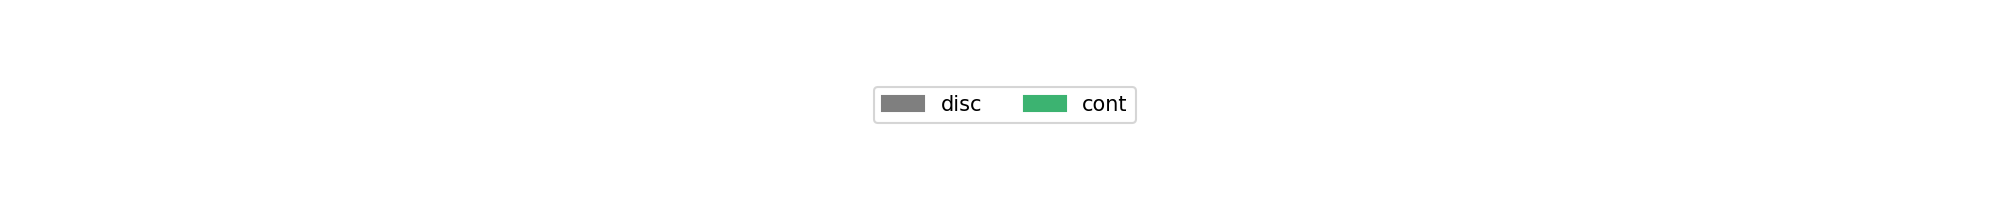

In [20]:
draw_BN(bn_mehra, mehra_types, 'mehra_net')

In [17]:
params = parameter_learning(mehra, mehra_types, bn_mehra)